A new DNN for training with single class labels instead of vector labels.

Intuition: Most of the vector labels have positive probabilities for background. The model may put too much weight on #b.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import DNN2_utils
from torch.utils.data import Dataset, DataLoader, sampler

import numpy as np 
import pandas as pd
from joblib import load 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import helper functions.
import mfcc_label 
import get_prob

# Configurations 
device = DNN2_utils.device
dtype = DNN2_utils.dtype

# DNN Architecture Hyperparameters
minibatch_size = 64

In [3]:
# Read the data
df_train_val = pd.read_csv('processed_data/dnn_never_train.csv')
df_test = pd.read_csv('processed_data/dnn_never_test.csv')

# Some columns are recorded as string although they are arrays.
DNN2_utils.column_str_to_numpy(df_train_val, 'mfcc')
DNN2_utils.column_str_to_numpy(df_train_val, 'label')
DNN2_utils.column_str_to_numpy(df_test, 'mfcc')
DNN2_utils.column_str_to_numpy(df_test, 'label')

# Split the train set into train and validation sets.
# df_train_pre stands for training data before preprocessing (e.g. before upsampling)
df_train_pre, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42)
df_train_pre.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Create a single class label (type: int) which is the highest probability class in the label vector (type: 14x1 array).
df_train_pre['single_class_label'] = df_train_pre['label'].apply(lambda x: np.argmax(x))
df_val['single_class_label'] = df_val['label'].apply(lambda x: np.argmax(x))
df_test['single_class_label'] = df_test['label'].apply(lambda x: np.argmax(x))

# Assign the label as the single class label.
df_train_pre['label'] = df_train_pre['single_class_label'] 
df_val['label'] = df_val['single_class_label']
df_test['label'] = df_test['single_class_label']
display(df_train_pre) 

df_train = df_train_pre.copy() 


,mfcc,label,state_weights,single_class_label
0,"[-791.08295, 21.580734, 17.93341, 15.827632, 1...",12,{'h#': 1.0},12
1,"[-689.671, -32.7696, 19.98902, 21.299736, -18....",12,{'h#': 1.0},12
2,"[-682.85938, 61.687897, -16.395744, -7.3573151...",12,{'h#': 1.0},12
3,"[-537.14172, 23.381748, 1.685449, -3.3776209, ...",13,{'#b': 1.0},13
4,"[-552.37146, 38.625328, -44.881927, -17.255146...",13,{'#b': 1.0},13
...,...,...,...,...
12389,"[-695.60431, 46.363304, -54.836559, 2.7683876,...",12,{'h#': 1.0},12
12390,"[-541.0925, -20.647453, -19.415312, -3.7550635...",13,{'#b': 1.0},13
12391,"[-361.39725, 200.15135, -11.198521, -74.57884,...",13,{'#b': 1.0},13
12392,"[-560.96643, 85.371414, -12.350075, -33.760818...",13,{'#b': 1.0},13


In [4]:
from sklearn.utils import resample
pd.set_option('display.max_colwidth', None)

def upsample_multiple_minority(df: pd.DataFrame, colname: str):
    
    # Identify majority and minority classes
    majority_classes = [13, 14]
    minority_classes = list(range(13))

    # Find the size of the smallest majority class
    majority_class_size = df[colname].value_counts().nlargest(2).iloc[1]
    
    # List to hold the upsampled dataframes
    list_df = []

    # Loop through each minority class and upsample
    for class_value in minority_classes:
        df_minority_class = df[df[colname] == class_value]
        df_minority_upsampled = resample(df_minority_class, 
                                        replace=True,     # sample with replacement
                                        n_samples=majority_class_size,    # to match majority class size
                                        random_state=42) # reproducible results
        list_df.append(df_minority_upsampled)

    # Append majority classes without change
    df_majority = df[df[colname].isin(majority_classes)]
    list_df.append(df_majority)

    # Concatenate all dataframes
    df_upsampled = pd.concat(list_df)
    return df_upsampled

df_train = upsample_multiple_minority(df_train_pre, 'single_class_label')
df_train.reset_index(drop=True, inplace=True)
display(df_train)


,mfcc,label,state_weights,single_class_label
0,"[-598.41907, 101.633286, 12.79403, 55.521736, 19.245089, -21.813396, 7.297649, -8.991019, -8.672622, -6.903557, -26.458767, -8.404372, 0.834279, -21.950531, -5.637536, 2.426208, -15.428505, -8.187872, 4.573077, 1.4249396]",0,{'b-n': 1.0},0
1,"[-444.29684, 134.332, -26.399908, 37.182404, -12.692721, -21.350647, -36.88242, -39.475834, 5.9220443, -22.739956, 1.5711904, -15.277334, -18.523514, 20.431822, -14.853297, -10.769896, -7.6320653, -11.488972, -10.082881, -20.324902]",0,"{'#b': 0.3, 'b-n': 0.7}",0
2,"[-569.0472, 123.807236, 20.365025, 46.3256, -17.429394, -1.1377454, -18.012562, -26.986523, 8.747933, -14.695325, -11.327761, 5.5478487, -9.1613865, -11.8029175, -20.765472, -7.224439, 11.563768, 7.813733, -11.31823, -6.7472534]",0,"{'b-n': 0.8333333333333326, 'm-n': 0.16666666666666743}",0
3,"[-455.46777, 137.04718, -24.835773, 39.55927, -13.026936, -15.76074, -40.649616, -36.0811, 2.977964, -24.395159, 1.8094625, -15.524864, -21.317406, 19.14094, -11.661585, -12.749323, -6.702117, -8.408928, -10.878027, -18.299595]",0,"{'#b': 0.1, 'b-n': 0.9}",0
4,"[-416.9255, 116.8559, -42.253235, 4.1018977, -24.352783, -8.705617, -33.902008, -34.495148, 20.450006, -5.318508, 2.03583, -7.8365293, 19.346642, -11.834953, 2.828712, -10.317762, -17.260515, 6.0481505, -10.261354, -13.551632]",0,"{'e-eh': 0.4425, 'b-n': 0.5575}",0
...,...,...,...,...
32377,"[-354.37424, 153.82423, 2.520186, 8.557072, -62.9833, -70.76247, 31.027435, -28.974052, -1.3362603, -6.622672, -28.985481, 6.8635836, -23.302856, 17.592358, 1.9556779, -8.322697, 1.6778979, -5.984693, -9.394501, -18.730194]",13,{'#b': 1.0},13
32378,"[-541.0925, -20.647453, -19.415312, -3.7550635, -25.011345, 7.143332, -16.555939, -10.724681, 13.894259, 10.9246235, -23.339613, -8.79563, 11.684788, 1.0004408, 9.840512, -4.0137005, 5.4408083, -1.9365463, -10.327684, 1.4280273]",13,{'#b': 1.0},13
32379,"[-361.39725, 200.15135, -11.198521, -74.57884, -26.557076, -30.454882, -26.454899, -23.900236, -6.9710026, 10.228376, -62.84133, 9.395352, -1.8819872, -2.3180122, 9.137184, -22.453075, 9.633455, -0.8796562, -26.236694, -2.5513773]",13,{'#b': 1.0},13
32380,"[-560.96643, 85.371414, -12.350075, -33.760818, -45.370388, 11.333093, -5.9454966, -0.63891798, 3.0575819, -33.63752, 20.533573, 1.9418074, 10.326906, 4.8501635, -0.17955418, -8.1675873, -6.8336906, 10.819086, -4.0187063, -1.4526093]",13,{'#b': 1.0},13


In [5]:
class_proportions = pd.DataFrame([df_train_pre['label'].value_counts(normalize=True), 
                                  df_val['label'].value_counts(normalize=True), 
                                  df_test['label'].value_counts(normalize=True), 
                                  df_train['label'].value_counts(normalize=True)])

class_proportions = class_proportions.sort_values(by='label', axis=1)
class_proportions.index = ['df_train_pre', 'df_val', 'df_test', 'df_train']
class_proportions['sum'] = class_proportions.apply(lambda x: np.sum(x), axis=1) 
display(class_proportions) 



label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,sum
df_train_pre,0.016460,0.014442,0.014523,0.020332,0.019284,0.018799,0.011134,0.011780,0.011941,0.012829,0.013394,0.014523,0.149346,0.671212,1.0
df_val,0.010326,0.014843,0.013553,0.019684,0.020652,0.027751,0.012262,0.010649,0.010971,0.015489,0.013230,0.011939,0.141013,0.677638,1.0
df_test,0.014378,0.014552,0.014436,0.017972,0.017856,0.018494,0.012464,0.012638,0.012580,0.008290,0.008580,0.008522,0.143313,0.695924,1.0
df_train,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.057161,0.256902,1.0


In [6]:
# Convert dataset into a format that torch can read.
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        # Convert the DataFrame to tensors or appropriate formats initially
        self.mfcc = torch.tensor(np.vstack(dataframe['mfcc'].to_list()), dtype=torch.float32)
        self.label = torch.tensor(dataframe['label'].to_list(), dtype=torch.long) #Labels are one dimensional, do not use np.vstack.
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.mfcc)

    def __getitem__(self, idx):
        mfcc = self.mfcc[idx]
        label = self.label[idx]
        
        if self.transform:
            mfcc = self.transform(mfcc)

        return mfcc, label

# Create an instance of your dataset with your DataFrame
dataset_train = CustomDataset(df_train, train=True)  # Assuming df is your pandas DataFrame
dataset_val = CustomDataset(df_val, train=True)
dataset_test = CustomDataset(df_test,train=False)


# Create the DataLoader to handle batching
loader_train = DataLoader(dataset_train, batch_size=minibatch_size,
                          sampler=sampler.SubsetRandomSampler(range(len(df_train))))

loader_val = DataLoader(dataset_val, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_val))))

loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

In [7]:
for i, (x, y) in enumerate(loader_train):
    print(f'Batch: {i+1}')
    print(f'MFCC size: {x.shape}')
    print(f'Label size: {y}')
    if i >2:
        break

for i, (x,y) in enumerate(loader_train):
    print(f'Batch: {i+1}')
    print(f'MFCC: {x}')
    print(f'Label: {y}')
    if i>1:
        break 

Batch: 1
MFCC size: torch.Size([64, 20])
Label size: tensor([ 0, 10,  8, 13,  5,  5,  3,  4, 13, 13, 13, 11,  9,  6,  8,  9,  3,  6,
        10, 13,  1, 13, 13,  8, 11,  8,  9,  3, 13, 13,  6, 13,  1,  1, 12, 13,
         8,  1, 11, 13, 13, 13, 12,  3, 13, 11, 13, 13,  7, 13,  5, 10, 13,  6,
        13, 13, 11,  1,  7, 11,  0, 13, 13, 11])
Batch: 2
MFCC size: torch.Size([64, 20])
Label size: tensor([13,  6,  9, 13,  0, 10,  9,  4,  1,  6, 10,  8, 11, 13, 11, 13, 12,  8,
         8,  2, 13, 13,  6,  7, 13, 13, 12,  3, 12,  7, 13, 12,  8,  7, 10,  8,
         0,  5, 13, 11,  6, 13, 11, 13, 13, 13,  4,  5,  8,  6, 12, 11, 11,  6,
        13,  9,  5,  9,  4,  0,  6, 10,  4, 10])
Batch: 3
MFCC size: torch.Size([64, 20])
Label size: tensor([ 6,  0,  0, 10, 13,  9, 13,  1, 13, 12, 13, 12,  9, 11,  8,  9, 11,  6,
        12, 13,  1,  6,  1,  9,  4, 13,  6, 13, 12, 12, 12,  7, 13,  2,  5,  8,
        11,  9,  8,  4,  1,  1,  4, 13,  3, 12,  7, 13, 13, 11,  3, 12, 10, 10,
        10,  8,  6, 10,

In [8]:
class DNN_FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        # We may write a loop if we use the same activation function for all layers.
        self.fc1 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc2.weight) 
        self.fc3 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.fc5 = nn.Linear(input_size, num_classes)
        nn.init.kaiming_normal_(self.fc5.weight)
    
    def forward(self, x):
        x_temp = DNN2_utils.flatten(x) # Flatten the batch to convert dimensions from (N,C,1) to (N,-1)
        x_temp = F.relu(self.fc1(x_temp))
        x_temp = F.relu(self.fc2(x_temp))
        x_temp = F.relu(self.fc3(x_temp))
        x_temp = F.relu(self.fc4(x_temp))
        scores = self.fc5(x_temp)
        return scores

def test_DNN_FC():
    input_size = len(df_train.iloc[0]['mfcc'])  # Feature dimension for mfcc
    num_classes = 1+df_train['label'].max() # Number of phoneme classes 
    x = torch.zeros((minibatch_size, input_size), dtype=dtype)  # minibatch size 64, feature dimension 20
    model = DNN_FC(input_size, num_classes)
    scores = model(x)
    print(scores.size())  # you should see [minibatch_size, num_classes]
test_DNN_FC()

torch.Size([64, 14])


In [9]:
def train(model, optimizer, scheduler, epochs=1, print_every=50):

    """
    Train the model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - scheduler: Learning rate scheduler 

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_loss_lst = []
    train_loss_lst = []
    accuracy_val_max = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            scores = model(x)

            # Compare the output vector with the label vector using CrossEntropyLoss.
            criterion = nn.CrossEntropyLoss() 
            loss = criterion(scores, y)  

            # criterion = nn.BCEWithLogitsLoss() 
            # loss = criterion(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print()
                accuracy_val = DNN2_utils.check_accuracy_single_class(loader_val, model)
                val_loss = DNN2_utils.check_loss_single_class(loader_val, model) 
                if accuracy_val > accuracy_val_max:
                    accuracy_val_max = accuracy_val
                    model_params = model.state_dict()
                train_loss_lst.append(loss.item())
                val_loss_lst.append(val_loss.item()) 
        
        # Update the learning rate at every epoch.
        scheduler.step()

    # Plot the accuracy values
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.plot(train_loss_lst, label='Training Loss')

    # Add labels and title to the plot
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.show()
    return train_loss_lst, val_loss_lst
    
    

Epoch 0, Iteration 0, loss = 252.5910

Checking accuracy on validation set
Got 1953 / 3099 correct (63.02)
Epoch 0, Iteration 50, loss = 2.7076

Checking accuracy on validation set
Got 109 / 3099 correct (3.52)
Epoch 0, Iteration 100, loss = 2.5796

Checking accuracy on validation set
Got 2097 / 3099 correct (67.67)
Epoch 0, Iteration 150, loss = 2.5089

Checking accuracy on validation set
Got 2092 / 3099 correct (67.51)
Epoch 0, Iteration 200, loss = 2.5248

Checking accuracy on validation set
Got 2094 / 3099 correct (67.57)
Epoch 0, Iteration 250, loss = 2.3120

Checking accuracy on validation set
Got 2092 / 3099 correct (67.51)
Epoch 0, Iteration 300, loss = 2.2879

Checking accuracy on validation set
Got 1936 / 3099 correct (62.47)
Epoch 0, Iteration 350, loss = 2.2305

Checking accuracy on validation set
Got 2041 / 3099 correct (65.86)
Epoch 0, Iteration 400, loss = 2.1507

Checking accuracy on validation set
Got 1878 / 3099 correct (60.60)
Epoch 0, Iteration 450, loss = 2.3031

C

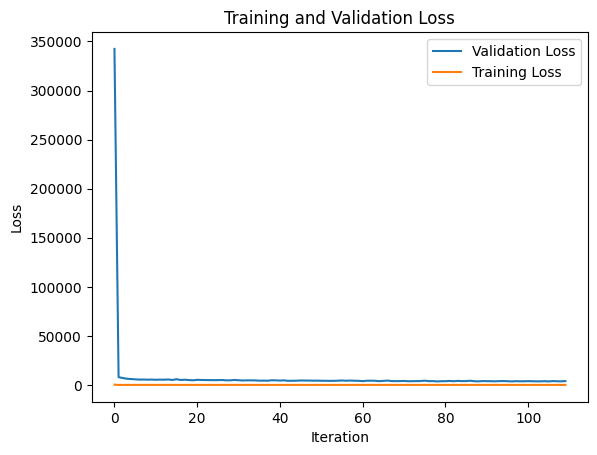

In [10]:
input_size = len(df_train.iloc[0]['mfcc'])
num_classes = 1+np.max(df_train['label']) 
learning_rate = 1e-2 
model = DNN_FC(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

train_loss_lst, val_loss_lst = train(model, optimizer, scheduler, epochs = 10)



[252.5910186767578, 2.7075932025909424, 2.5796029567718506, 2.508869171142578, 2.5248067378997803, 2.3119940757751465, 2.2879202365875244, 2.230515241622925, 2.1506690979003906, 2.3031270503997803, 2.308515787124634, 2.286315441131592, 2.185206890106201, 2.4424986839294434, 2.02234148979187, 2.227043867111206, 2.1902496814727783, 2.1621007919311523, 2.0174365043640137, 2.022196054458618, 1.9232614040374756, 2.121117115020752, 2.0671679973602295, 2.004525899887085, 1.915819764137268, 1.8082506656646729, 1.8989812135696411, 2.0421030521392822, 1.8428897857666016, 1.9128098487854004, 1.8067209720611572, 1.7903108596801758, 1.9642648696899414, 1.7498060464859009, 1.5255604982376099, 1.6666004657745361, 1.7500404119491577, 1.5585001707077026, 1.8094896078109741, 1.7101553678512573, 1.6274210214614868, 1.8422222137451172, 1.7287400960922241, 1.677234411239624, 1.8140863180160522, 1.774903416633606, 1.8211572170257568, 1.665841817855835, 1.603879451751709, 1.7180612087249756, 1.72816610336303

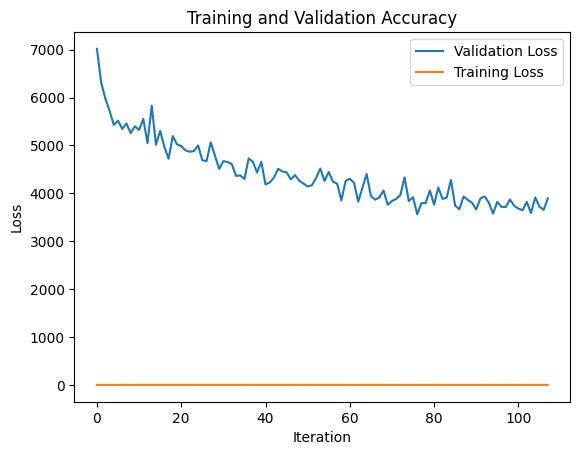

In [11]:
print(train_loss_lst)
print(val_loss_lst) 

# Plot the accuracy values
plt.plot(val_loss_lst[2:], label='Validation Loss')
plt.plot(train_loss_lst[2:], label='Training Loss')

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()




In [ ]:
DNN_utils.check_accuracy_single_class(loader_val, model)
DNN_utils.check_accuracy_single_class(loader_test, model) 
DNN_utils.check_accuracy_single_class(loader_train, model) 

loader_train_fortest = DataLoader(dataset_train, batch_size=1,
                                  sampler = sampler.SequentialSampler(range(len(df_train))))
DNN_utils.check_accuracy_single_class(loader_train_fortest, model) 


In [ ]:
def infer_probabilities(loader, model):
    if loader.dataset.train:
        print('Getting estimated probabilities on validation set')
    else:
        print('Getting estimated probabilities on test set') 
    model.eval()  # set model to evaluation mode
    probabilities_dict = {} 
    batch_size = loader.batch_size
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            scores = model(x) 
            probabilities = torch.softmax(scores, dim=1) 

            # Save the probabilities with the corresponding row index
            for i in range(len(probabilities)):
                probabilities_dict[idx * batch_size + i] = probabilities[i].numpy()
    
    return probabilities_dict


def find_emission(loader, model, scale = False):
    '''
    Find emission probabilities for a given data loader and model.
    Consider changing this function if it takes too long. Currently: O(n) 
    Args:
        loader: torch Data loader
        model: torch DNN model
        scale: Boolean: Set true to scale the output probability of DNN.
    Returns:
        emission_df: Dataframe for emission probabilities.
    '''
    # Get the inferred probabilities for each class (12 states, background and silence)
    probabilities_dict = infer_probabilities(loader, model) 
    emission = probabilities_dict
    # Get the prior vector and the transition probabilities. We don't need the transition probabilities.
    prior_vector, _ = get_prob.main(rerun=False) 
    
    # For each key=row_idx and val=prob_array, convert the inferred probabilities into emission.
    for key, val in emission.items():
        # Slice val to exclude the probabilities for background and silence.
        if scale == True:
            log_prob = np.where(val > 0, np.log(val), -np.inf)   # Get the log probabilities. 
            log_prob = log_prob[:-2]  # Exclude the background and silence in the emission probability calculation. 
            emission[key] = [log_prob-prior_vector]  # Divide by prior vector in the log space. 
        else:
            emission[key] = [val] 

    emission_df = pd.DataFrame.from_dict(emission, orient='index', columns=['Emission']) 
    return emission_df 

In [ ]:
prior_vector, _ = get_prob.main(rerun=True)
estimate_prob = infer_probabilities(loader_test, model)
emission_data = find_emission(loader_test, model)



In [ ]:
def path_to_emission(file_path_wav: str, file_path_phn: str):
    '''
    Given the path of a file, get the emission probabilities.
    Args:
        file_path: Path of the audio file as a string.
    Returns:
        emit: pd.dataframe
            Emission probabilities for each frame in the audio file.
    '''
    df_test = mfcc_label.prepare_data(file_path_phn,file_path_wav)
    DNN_utils.column_str_to_numpy(df_test, 'mfcc')
    DNN_utils.column_str_to_numpy(df_test, 'label')
    # Convert dataframe into a loader so that torch can work with.
    dataset_test = CustomDataset(df_test,train=False)
    loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

    emission_data = find_emission(loader_test, model)
    return emission_data
    

path_to_emission('timit/data/TRAIN/DR4/MDCD0/SX425.WAV','timit/data/TRAIN/DR4/MDCD0/SX425.PHN')

In [ ]:
def get_emission_all_paths(path_type: str = 'test'):
    paths = load('processed_data/train_test_dataset_never.joblib')[path_type]
    data = {}
    for i in range(len(paths)):
        file_path_wav, file_path_phn, file_path_word = paths[i]
        emission_data = path_to_emission(file_path_wav, file_path_phn)
        data[(file_path_wav, file_path_phn, file_path_word)] = emission_data

    return data
data = get_emission_all_paths() 

from joblib import dump
dump(data, "processed_data/test_data_for_hmm.joblib")